In [1]:
import uproot as ur
import uproot_methods as urm
import numpy as np
import awkward
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences

import tools
from four_jet_network import FourJetNetwork

filename = 'user.jagrundy.20736236._000001.MiniNTuple.root'

print("opening file")
s_table = tools.open_file(filename, sort_by="tag")

Using TensorFlow backend.


opening file
sorting data by tag


# Stage 1, pt classifier

- if 4th jet found, keep selection based on this method
- if not, proceed to stage 2

In [2]:
print("filtering from", len(s_table), "total events")

# filter so we get events with 3 or 4 b-jets, and 3 tags
nb34 = (s_table.nbjets == 3) | (s_table.nbjets == 4) # 3 or 4 b-jets
nj4 = s_table.njets >= 4 # at least 4 jets
nt3 = s_table.nbtags==3  # 3 b-tags
events = s_table[nb34 & nt3 & nj4]

# and ensure that the 3 tags are actually correct
# this results in very little event loss
events = events[events.truth[:,0] == 1]
events = events[events.truth[:,1] == 1]
events = events[events.truth[:,2] == 1]

n_events = len(events)
print(n_events)

filtering from 777150 total events
302694


In [3]:
cutoff = 10  # np.max(events.njets)
padding_val = 0

# pad events out to 'cutoff' events
events = tools.pad(events, cutoff)
# boost/rotate
events = tools.boost_and_rotate(events)

/home/callum/anaconda3/envs/437env/lib/python3.8/site-packages/uproot_methods/classes/TLorentzVector.py:181: RuntimeWarning: invalid value encountered in true_divide
  return self._trymemo("eta", lambda self: self.awkward.numpy.arcsinh(self.z / self.awkward.numpy.sqrt(self.x**2 + self.y**2)))


Don't worry if you see a warning about dividing by zero, fixing that!


 11%|█         | 33571/302694 [00:00<00:01, 173778.65it/s]

302694 events are advancing to stage 2 since we didn't pick a 4th jet


100%|██████████| 302694/302694 [00:01<00:00, 161019.77it/s]


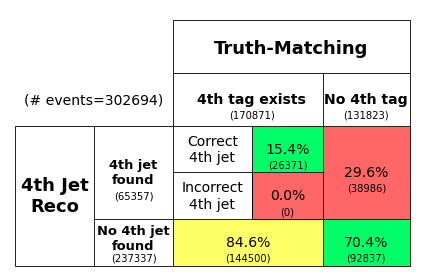

(15.43328007678307,
 0.0,
 84.56671992321694,
 29.57450520774068,
 70.42549479225931)

In [4]:
# separate the 3 first jets from the rest since they're already tagged correctly
# (given our filtering procedure above)
px_3, px_rest = events.resolved_lv.p3.x[:, :3], events.resolved_lv.p3.x[:, 3:]
py_3, py_rest = events.resolved_lv.p3.y[:, :3], events.resolved_lv.p3.y[:, 3:]
# find the best jet from _rest that fits with _3, in terms of pt sum = 0
px_3_sums = np.repeat(np.sum(px_3, axis=1).reshape(-1, 1), cutoff-3, axis=1)
py_3_sums = np.repeat(np.sum(py_3, axis=1).reshape(-1, 1), cutoff-3, axis=1)

px_sums = np.abs(px_rest + px_3_sums)
py_sums = np.abs(py_rest + py_3_sums)

magnitudes = np.sqrt(px_sums**2 + py_sums**2)
lowest_vals = np.min(magnitudes, axis=1)
lowest_indices = np.argmin(magnitudes, axis=1)

# lower values = more certainty
# let's set an arbitrary threshold,
# and say if lowest_val > thresh, pick no jet
thresh = 0.001
lowest_indices[lowest_vals>thresh] = cutoff-3

# also if the event was fine before adding a 4th jet, pick no jet
# this ends up having a small effect
px_sums_no_4th = np.abs(px_3_sums[:,0])
py_sums_no_4th = np.abs(py_3_sums[:,0])
magnitudes_no_4th = np.sqrt(px_sums_no_4th**2 + py_sums_no_4th**2)
lowest_indices[magnitudes_no_4th<thresh] = cutoff-3

# put this in a better format
selection_index = lowest_indices + 3
selections = np.zeros((len(events.truth), cutoff+1), dtype=int)
for i, s in enumerate(selection_index):
    selections[i][s] = 1
# chop off last index so selection = [0,...,0] for no selection
selections = selections[:, :-1]

picked_no_4th = np.sum(selections, axis=1) == 0

print(len(picked_no_4th),
      "events are advancing to stage 2 since we didn't pick a 4th jet")

# compare to tag_u, truth_u
tools.evaluate_model(events.truth, events.tag, selections, savename='after_stage_1')

# Stage 2: The 4-jet NN Gauntlet

- make 4-jet nn
- split events into 4-jet groups
- take best-fit jet in terms of 4-jet nn results

## To make the 4-jet nn, just copy the 4b notebook

Don't worry if you see a warning about dividing by zero, fixing that!
Train on 45749 samples, validate on 6537 samples
Epoch 1/400
45749/45749 [==============================] - 0s 8us/step - loss: 0.6549 - accuracy: 0.6000 - val_loss: 0.6488 - val_accuracy: 0.6004
Epoch 2/400
45749/45749 [==============================] - 0s 6us/step - loss: 0.6482 - accuracy: 0.6034 - val_loss: 0.6428 - val_accuracy: 0.6049
Epoch 3/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.6427 - accuracy: 0.6074 - val_loss: 0.6376 - val_accuracy: 0.6096
Epoch 4/400
45749/45749 [==============================] - 0s 6us/step - loss: 0.6379 - accuracy: 0.6117 - val_loss: 0.6329 - val_accuracy: 0.6145
Epoch 5/400
45749/45749 [==============================] - 0s 6us/step - loss: 0.6336 - accuracy: 0.6158 - val_loss: 0.6287 - val_accuracy: 0.6206
Epoch 6/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.6295 - accuracy: 0.6209 - val_loss: 0.6247 - val_accuracy: 0.6258

45749/45749 [==============================] - 0s 5us/step - loss: 0.5309 - accuracy: 0.7315 - val_loss: 0.5315 - val_accuracy: 0.7291
Epoch 56/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5301 - accuracy: 0.7324 - val_loss: 0.5306 - val_accuracy: 0.7297
Epoch 57/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5293 - accuracy: 0.7328 - val_loss: 0.5298 - val_accuracy: 0.7294
Epoch 58/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5286 - accuracy: 0.7332 - val_loss: 0.5290 - val_accuracy: 0.7298
Epoch 59/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5279 - accuracy: 0.7336 - val_loss: 0.5282 - val_accuracy: 0.7306
Epoch 60/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5272 - accuracy: 0.7337 - val_loss: 0.5275 - val_accuracy: 0.7312
Epoch 61/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5265 - accuracy: 0.7338 - val_loss: 0.5268 

45749/45749 [==============================] - 0s 5us/step - loss: 0.5062 - accuracy: 0.7452 - val_loss: 0.5074 - val_accuracy: 0.7439
Epoch 111/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5060 - accuracy: 0.7458 - val_loss: 0.5072 - val_accuracy: 0.7436
Epoch 112/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5057 - accuracy: 0.7457 - val_loss: 0.5070 - val_accuracy: 0.7433
Epoch 113/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5054 - accuracy: 0.7458 - val_loss: 0.5067 - val_accuracy: 0.7456
Epoch 114/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5052 - accuracy: 0.7463 - val_loss: 0.5065 - val_accuracy: 0.7453
Epoch 115/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5049 - accuracy: 0.7469 - val_loss: 0.5063 - val_accuracy: 0.7447
Epoch 116/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.5047 - accuracy: 0.7464 - val_loss: 0

45749/45749 [==============================] - 0s 5us/step - loss: 0.4950 - accuracy: 0.7515 - val_loss: 0.4979 - val_accuracy: 0.7442
Epoch 166/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4949 - accuracy: 0.7520 - val_loss: 0.4978 - val_accuracy: 0.7445
Epoch 167/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4947 - accuracy: 0.7520 - val_loss: 0.4976 - val_accuracy: 0.7453
Epoch 168/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4945 - accuracy: 0.7520 - val_loss: 0.4975 - val_accuracy: 0.7451
Epoch 169/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4944 - accuracy: 0.7525 - val_loss: 0.4974 - val_accuracy: 0.7453
Epoch 170/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4942 - accuracy: 0.7522 - val_loss: 0.4972 - val_accuracy: 0.7458
Epoch 171/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4941 - accuracy: 0.7525 - val_loss: 0

45749/45749 [==============================] - 0s 5us/step - loss: 0.4867 - accuracy: 0.7577 - val_loss: 0.4912 - val_accuracy: 0.7520
Epoch 221/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4866 - accuracy: 0.7579 - val_loss: 0.4911 - val_accuracy: 0.7519
Epoch 222/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4864 - accuracy: 0.7581 - val_loss: 0.4910 - val_accuracy: 0.7517
Epoch 223/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4863 - accuracy: 0.7580 - val_loss: 0.4909 - val_accuracy: 0.7525
Epoch 224/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4862 - accuracy: 0.7579 - val_loss: 0.4908 - val_accuracy: 0.7519
Epoch 225/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4860 - accuracy: 0.7580 - val_loss: 0.4907 - val_accuracy: 0.7517
Epoch 226/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4859 - accuracy: 0.7585 - val_loss: 0

45749/45749 [==============================] - 0s 5us/step - loss: 0.4797 - accuracy: 0.7625 - val_loss: 0.4865 - val_accuracy: 0.7562
Epoch 276/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4796 - accuracy: 0.7630 - val_loss: 0.4864 - val_accuracy: 0.7565
Epoch 277/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4795 - accuracy: 0.7629 - val_loss: 0.4864 - val_accuracy: 0.7565
Epoch 278/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4794 - accuracy: 0.7630 - val_loss: 0.4863 - val_accuracy: 0.7563
Epoch 279/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4793 - accuracy: 0.7629 - val_loss: 0.4862 - val_accuracy: 0.7566
Epoch 280/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4792 - accuracy: 0.7630 - val_loss: 0.4862 - val_accuracy: 0.7565
Epoch 281/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4791 - accuracy: 0.7633 - val_loss: 0

45749/45749 [==============================] - 0s 5us/step - loss: 0.4748 - accuracy: 0.7660 - val_loss: 0.4835 - val_accuracy: 0.7586
Epoch 331/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4747 - accuracy: 0.7658 - val_loss: 0.4834 - val_accuracy: 0.7583
Epoch 332/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4746 - accuracy: 0.7659 - val_loss: 0.4834 - val_accuracy: 0.7589
Epoch 333/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4746 - accuracy: 0.7660 - val_loss: 0.4833 - val_accuracy: 0.7581
Epoch 334/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4745 - accuracy: 0.7660 - val_loss: 0.4833 - val_accuracy: 0.7580
Epoch 335/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4744 - accuracy: 0.7662 - val_loss: 0.4833 - val_accuracy: 0.7585
Epoch 336/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4743 - accuracy: 0.7662 - val_loss: 0

45749/45749 [==============================] - 0s 5us/step - loss: 0.4709 - accuracy: 0.7695 - val_loss: 0.4811 - val_accuracy: 0.7611
Epoch 386/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4708 - accuracy: 0.7691 - val_loss: 0.4810 - val_accuracy: 0.7611
Epoch 387/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4708 - accuracy: 0.7693 - val_loss: 0.4810 - val_accuracy: 0.7611
Epoch 388/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4707 - accuracy: 0.7691 - val_loss: 0.4809 - val_accuracy: 0.7609
Epoch 389/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4707 - accuracy: 0.7693 - val_loss: 0.4809 - val_accuracy: 0.7611
Epoch 390/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4706 - accuracy: 0.7695 - val_loss: 0.4809 - val_accuracy: 0.7609
Epoch 391/400
45749/45749 [==============================] - 0s 5us/step - loss: 0.4705 - accuracy: 0.7693 - val_loss: 0

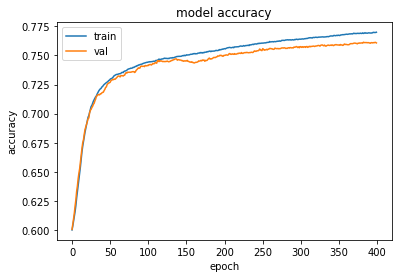

In [5]:
# filter so we get events with 4 jets, 3 or 4 b-jets, and 3 tags
j4 = (s_table.njets == 4) # 4 jets
b34 = (s_table.nbjets == 3) | (s_table.nbjets == 4) # 3 or 4 b-jets
nt3 = s_table.nbtags==3  # 3 b-tags
events_4j = s_table[j4 & b34 & nt3]
events_4j = events_4j[events_4j.truth[:,0] == 1]
events_4j = events_4j[events_4j.truth[:,1] == 1]
events_4j = events_4j[events_4j.truth[:,2] == 1]
# pad, boost, rotate
events_4j = tools.pad(events_4j, length=4)
events_4j = tools.boost_and_rotate(events_4j)
# create network
nn = FourJetNetwork(events_4j)
nn.learn()
#nn.evaluate()

In [6]:
# the network score for some events is given by
def score(nn, evs):
    """Note: this expects evs to be events of 4 jets"""
    nn_input = tools.scale_nn_input(evs)
    nn_score = nn.model.predict(nn_input)
    return nn_score.flatten()

1661359
Train on 1162951 samples, validate on 166137 samples
Epoch 1/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.3705 - accuracy: 0.8858 - val_loss: 0.5899 - val_accuracy: 0.7496
Epoch 2/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.2344 - accuracy: 0.9126 - val_loss: 0.5376 - val_accuracy: 0.7477
Epoch 3/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.2129 - accuracy: 0.9118 - val_loss: 0.5234 - val_accuracy: 0.7478
Epoch 4/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.2043 - accuracy: 0.9130 - val_loss: 0.5127 - val_accuracy: 0.7518
Epoch 5/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1987 - accuracy: 0.9137 - val_loss: 0.5015 - val_accuracy: 0.7533
Epoch 6/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1934 - accuracy: 0.9148 - val_loss: 0.4888 - val_accuracy: 0.7600
Epoch 7/300
1162951/1162951 [====

1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1693 - accuracy: 0.9251 - val_loss: 0.4355 - val_accuracy: 0.7908
Epoch 55/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1692 - accuracy: 0.9251 - val_loss: 0.4352 - val_accuracy: 0.7910
Epoch 56/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1691 - accuracy: 0.9251 - val_loss: 0.4348 - val_accuracy: 0.7912
Epoch 57/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1690 - accuracy: 0.9251 - val_loss: 0.4346 - val_accuracy: 0.7911
Epoch 58/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1689 - accuracy: 0.9252 - val_loss: 0.4342 - val_accuracy: 0.7913
Epoch 59/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1688 - accuracy: 0.9252 - val_loss: 0.4342 - val_accuracy: 0.7914
Epoch 60/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1687 - accuracy

Epoch 108/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1668 - accuracy: 0.9261 - val_loss: 0.4287 - val_accuracy: 0.7943
Epoch 109/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1668 - accuracy: 0.9262 - val_loss: 0.4282 - val_accuracy: 0.7944
Epoch 110/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1668 - accuracy: 0.9261 - val_loss: 0.4286 - val_accuracy: 0.7941
Epoch 111/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1668 - accuracy: 0.9262 - val_loss: 0.4281 - val_accuracy: 0.7945
Epoch 112/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1668 - accuracy: 0.9262 - val_loss: 0.4283 - val_accuracy: 0.7943
Epoch 113/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1667 - accuracy: 0.9262 - val_loss: 0.4280 - val_accuracy: 0.7949
Epoch 114/300
1162951/1162951 [==============================] - 6s 5us/step - los

1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1656 - accuracy: 0.9269 - val_loss: 0.4247 - val_accuracy: 0.7968
Epoch 162/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1656 - accuracy: 0.9269 - val_loss: 0.4252 - val_accuracy: 0.7970
Epoch 163/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1656 - accuracy: 0.9269 - val_loss: 0.4248 - val_accuracy: 0.7971
Epoch 164/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1656 - accuracy: 0.9269 - val_loss: 0.4248 - val_accuracy: 0.7973
Epoch 165/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1656 - accuracy: 0.9269 - val_loss: 0.4245 - val_accuracy: 0.7972
Epoch 166/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1655 - accuracy: 0.9270 - val_loss: 0.4247 - val_accuracy: 0.7975
Epoch 167/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1655 - ac

1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1643 - accuracy: 0.9274 - val_loss: 0.4213 - val_accuracy: 0.7993
Epoch 215/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1642 - accuracy: 0.9275 - val_loss: 0.4210 - val_accuracy: 0.7993
Epoch 216/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1642 - accuracy: 0.9275 - val_loss: 0.4210 - val_accuracy: 0.7995
Epoch 217/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1641 - accuracy: 0.9276 - val_loss: 0.4207 - val_accuracy: 0.7994
Epoch 218/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1641 - accuracy: 0.9275 - val_loss: 0.4205 - val_accuracy: 0.7996
Epoch 219/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1641 - accuracy: 0.9276 - val_loss: 0.4206 - val_accuracy: 0.7997
Epoch 220/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1640 - ac

1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1626 - accuracy: 0.9286 - val_loss: 0.4158 - val_accuracy: 0.8028
Epoch 268/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1626 - accuracy: 0.9286 - val_loss: 0.4161 - val_accuracy: 0.8025
Epoch 269/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1626 - accuracy: 0.9286 - val_loss: 0.4160 - val_accuracy: 0.8026
Epoch 270/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1626 - accuracy: 0.9287 - val_loss: 0.4158 - val_accuracy: 0.8030
Epoch 271/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1625 - accuracy: 0.9287 - val_loss: 0.4157 - val_accuracy: 0.8028
Epoch 272/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1625 - accuracy: 0.9286 - val_loss: 0.4156 - val_accuracy: 0.8031
Epoch 273/300
1162951/1162951 [==============================] - 6s 5us/step - loss: 0.1625 - ac

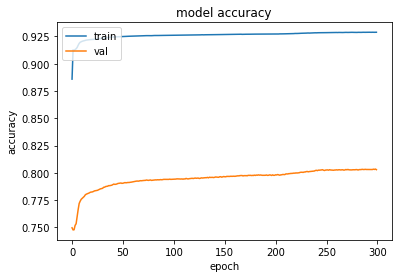

In [7]:
scores = np.zeros((len(events), cutoff), dtype=float)

# each group has this size
group_len = len(events.truth[picked_no_4th])

group_events = awkward.Table()
group_events.truth = np.concatenate([events.truth[picked_no_4th][:,[0,1,2,i]] for i in range(3, cutoff)])
group_events.tag = np.concatenate([events.tag[picked_no_4th][:,[0,1,2,i]] for i in range(3, cutoff)])
pt = np.concatenate([events.resolved_lv.pt[picked_no_4th][:,[0,1,2,i]] for i in range(3, cutoff)])
eta = np.concatenate([events.resolved_lv.eta[picked_no_4th][:,[0,1,2,i]] for i in range(3, cutoff)])
phi = np.concatenate([events.resolved_lv.phi[picked_no_4th][:,[0,1,2,i]] for i in range(3, cutoff)])
E = np.concatenate([events.resolved_lv.E[picked_no_4th][:,[0,1,2,i]] for i in range(3, cutoff)])
group_events.resolved_lv = urm.TLorentzVectorArray.from_ptetaphie(
    pt, eta, phi, E)
print(len(group_events.truth))
group_nn = FourJetNetwork(group_events)
group_nn.learn(epochs=300)
#group_nn.evaluate()

In [8]:
group_scores = score(group_nn, group_events)
print(group_scores.shape)
group_scores = group_scores.reshape((group_len, cutoff-3))

(1661359,)


In [9]:
maxes = np.max(group_scores, axis=1)
select = np.argmax(group_scores,axis=1)
select[maxes < 0.5] = cutoff
nn_selections = np.zeros((len(select), cutoff+1), dtype=int)
for i, s in enumerate(select):
    nn_selections[i][s] = 1

# chop off the last "no selection" jet
nn_selections = nn_selections[:,:-1]

# and actually evaluate
#tools.evaluate_model(events.truth[picked_no_4th], events.tag[picked_no_4th], nn_selections)

100%|██████████| 302694/302694 [00:01<00:00, 156261.62it/s]


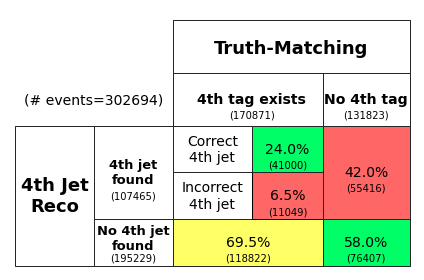

(23.994709459182655,
 6.466281580841687,
 69.53900895997566,
 42.03818756969573,
 57.96181243030426)

In [10]:
# edit the selections from earlier
selections[picked_no_4th] = nn_selections
tools.evaluate_model(events.truth, events.tag, selections, savename="after_stage_2")